In [1]:
import pandas as pd
import sqlite3 as sq

So, we import the pandas and the sqlite framework to start off.
* _**pandas**_ is a software library written for the Python programming language for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series.
* _**sqlite3**_ is a python module used to integrate the sqlite3 database with python

In [2]:
conn=sq.connect("db.sqlite3")

To use sqlite3 module, you must first create a 'connection' object that represents the database. 
Here, we use the **conn** as an object to represent i.e. connect the database  

In [3]:
df = pd.read_sql_query("select * from product_item;", conn)
u_df = pd.read_sql_query("select * from activity_activity;", conn)

We then load the data from the database tables into a structure called ***DataFrame***

A DataFrame is a two-dimensional data structure, i.e., data is aligned in a tabular fashion in rows and columns. Pandas DataFrame consists of three principal components, the data, rows, and columns.

Here, ***df*** is a DataFrame used to store the ***product_item*** table from the data base wich stores all *class Item* model object.
Similarly, ***u_df*** is a DataFrame used to store the ***activity_activity*** table which consists of user activity

*To know more about the database, refer to section 3.3.1 L. db.sqlite3 of the document*

To visualize the dataframe in actoin, we perform the following action:

In [4]:
df.head(2)

,id,title,price_currency,price,content,image,condition,price_negotiability,item_available_for,date_posted,slug,author_id,category_id,sub_category_id,sold
0,1,Necklace,NPR,450.0,lipsum,item_pics/images_1.jpg,Brand New,0,Sale,2020-03-08 11:32:18.820751,necklace,1,1,4,0
1,2,Hyundai Elantra,NPR,45000.0,lipsum,item_pics/Edge-Of-World_Hz3Kvzo.jpg,Used (Worn Out),1,Sale,2020-03-08 14:51:00.170484,hyundai-elantra,1,2,16,0


In [5]:
u_df.head(2)

,id,verb,target_id,date_created,target_ct_id,user_id
0,1,Viewed item,1,2020-03-08 11:54:59.889893,10,1
1,2,Viewed item,1,2020-03-08 12:04:10.356637,10,1


the ***.head(2)*** lists the top 2 rows of the dataframe.

Now that the data has been loaded, we perform some mathematical operations, in our case a ***TF-IDF Vectorizer***

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

* ***sklearn*** aka ***(Scikit-learn)*** is a free machine learning library for Python. It features various algorithms like support vector machine, random forests, and k-neighbours, and it also supports Python numerical and scientific libraries like NumPy and SciPy.

_sklearn_ provides us the tools to create a TF-IDF Vectorizer
#### TF-IDF Vectorizer

In [7]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df=0, stop_words='english')

tfidf_matrix = tf.fit_transform(df['content'])

The TF*IDF algorithm is used to weigh a keyword in any document and assign the importance to that keyword based on the number of times it appears in the document. Put simply, the higher the TF*IDF score (weight), the rarer and more important the term, and vice versa.

Each word or term has its respective TF and IDF score. The product of the TF and IDF scores of a term is called the TF*IDF weight of that term.

The **TF (term frequency)** of a word is the number of times it appears in a document. When you know it, you’re able to see if you’re using a term too often or too infrequently.
    
    TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

The **IDF (inverse document frequency)** of a word is the measure of how significant that term is in the whole corpus.

    IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

![tfidf](https://miro.medium.com/max/364/1*3Ig7VSgscBzXaYa0Q-UM1w.png)
TF-IDF calculation

In Python, scikit-learn provides you a pre-built TF-IDF vectorizer that calculates the TF-IDF score for each document’s description, word-by-word.

In [8]:
print(tfidf_matrix[1])

  (0, 2129)	1.0


Here, the ***tfidf_matrix*** is the matrix containing each word and its TF-IDF score with regard to each document, or item in this case. Also, stop words are simply words that add no significant value to our system, like ‘an’, ‘is’, ‘the’, and hence are ignored by the system.

Now, we have a representation of every item in terms of its description. Next, we need to calculate the relevance or similarity of one document to another.

#### Vector Space Model
In this model, each item is stored as a vector of its attributes (which are also vectors) in an n-dimensional space, and the angles between the vectors are calculated to determine the similarity between the vectors.

![](https://miro.medium.com/max/414/1*LWoRop9T6hC7zhi32UxhCQ.png)

Documents represented as vectors

The method of calculating the user’s likes / dislikes / measures is calculated by taking the cosine of the angle between the user profile vector (Ui ) and the document vector; or in our case, the angle between two document vectors.
The ultimate reason behind using cosine is that the value of cosine will increase as the angle between vectors with decreases, which signifies more similarity.
The vectors are length-normalized, after which they become vectors of length 1.

#### Calculating Cosine Similarity
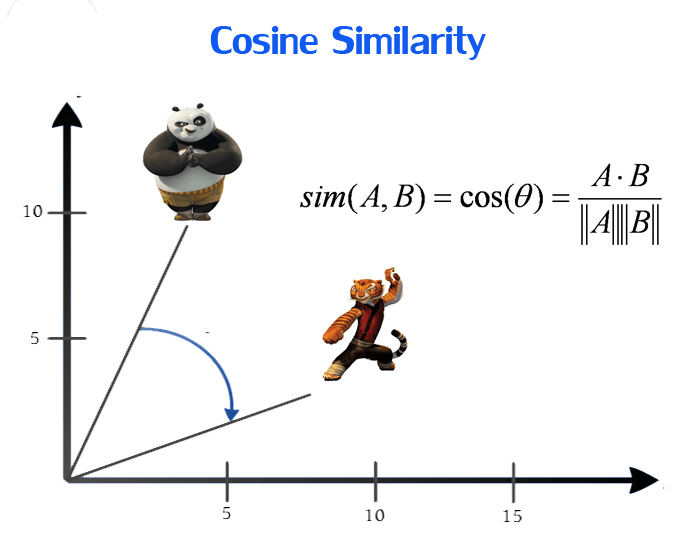

Cosine similarity

In [9]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
results = {}
for idx, row in df.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], df['id'][i]) for i in similar_indices]
    results[row['id']] = similar_items[1:]

Here we’ve calculated the cosine similarity of each item with every other item in the dataset, and then arranged them according to their similarity with item ***i***, and stored the values in ***results***.

##### Making a recommendation
So here comes the part where we finally get to see our recommender system in action.

In [10]:
def item(id):  
  return df.loc[df['id'] == id]['title'].tolist()[0].split(' - ')[0] 

def recommend(item_id, num):
    print("Recommending " + str(num) + " products similar to " + item(item_id) + "...")   
    print("-------")
    recs = results[item_id][:num]  
    for rec in recs:
        print("Recommended: " + item(rec[1]) + " (score:" + str(rec[0]) + ")")

function ***item(id)*** returns the *title* of the parameter ***id*** ie title of the item in dataframe

function ***recommend(item_id, num)*** returns the *'num'* number of *recommended items* similar to item with id ***item_id***

Let's see an example:

In [11]:
recommend(3, 4)

Recommending 4 products similar to Samsung Galaxy S10e...
-------
Recommended: Samsung Galaxy S10 (score:0.3388675864995107)
Recommended: Samsung Galaxy S10 (score:0.3301949324341461)
Recommended: Samsung Galaxy Note 10 (score:0.20155566114586354)
Recommended: Samsung Galaxy S10 5g (score:0.19530303866638044)


For the purpose of our BuyandBye django project, we redefine the recommend function as follows to return the id of the recommended item so we can filter the ids to display items.

```python
def recommend(item_id, num):
    """ recommends num items similar to item_id"""
    recs = results[item_id][:num]
    product_id = []
    for rd in recs:
        """iteraring each result obtained from cosine similarity and assigning them from tuple"""
        product_id.append(rd[1])
    return product_id
```

This redefined function returns a python list with ids of recommended products.

### User based recommendation

Then for recommending items catered to the user, we apply a very simple method based on the user activity. 

***'u_df'*** dataframe consists of the table with activities of the user.

In [12]:
#filtering user
u_df.user_id = 1
#filtering based on viewed item
u_df.verb = "Viewed item"

So, we clean the data accordingly. 

using ***.user_id*** and  ***.verb*** to filter the dataframe for specific user and activity

In [13]:
u_df.head(5)

,id,verb,target_id,date_created,target_ct_id,user_id
0,1,Viewed item,1,2020-03-08 11:54:59.889893,10,1
1,2,Viewed item,1,2020-03-08 12:04:10.356637,10,1
2,3,Viewed item,1,2020-03-08 12:09:06.035377,8,1
3,4,Viewed item,1,2020-03-08 12:11:13.468785,10,1
4,5,Viewed item,2,2020-03-08 14:51:00.367496,10,1


Here, the ***target_ct_id*** contains the *item ids* of the viewed items by the user.

We extract the item viewed most number of time, and recommend items similar to that item.

In [14]:
#calculating most recurring item
most_repeated = u_df.target_id.mode()
most_repeated

0    1
dtype: int64

As we can see the ***'mode()'***  function returns a single most repeated item's id, we capture that id and then recommend based on that id

In [15]:
#extracting index of the most recurred item
id_index = most_repeated[0]
id_index

1

In [16]:
recommend(id_index, 5)

Recommending 5 products similar to Necklace...
-------
Recommended: Hyundai Elantra (score:1.0)
Recommended: Samsung Galaxy Note 10 (score:0.0)
Recommended: Samsung Galaxy S10e (score:0.0)
Recommended: Samsung Galaxy S10 lite (score:0.0)
Recommended: Samsung Galaxy S10 (score:0.0)


Again, as before For the purpose of our BuyandBye django project, we define a function that takes the user id as parameter to recommended items specific to that user.

```python
def user_recommend(req_user_id):
    user_df.user_id = req_user_id  # filtering based on the user id
    user_df.verb = "Viewed item"    # filtering to 'viewed item' only
    mode = user_df.target_id.mode()  # getting the most repeated item
    mode_id = mode[0]  # extracting the id of mode from the mode table
    return recommend(mode_id, 20)
```

This function returns a python list with ids of recommended products for that specific user. We filter based on that list of ids.